# ConvNet in Pytorch for MNIST
1. Dataset
2. Model
3. Training
4. Introspection

In [1]:
import os
import tqdm
import math
import numpy as np
import seaborn as sns
from itertools import chain
from collections import defaultdict
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader

%matplotlib inline

data_path = os.environ['MS_DATA_PATH']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1. Le Data
- 1.1 Download data
- 1.2 Sample images
- 1.3 Visualise dataset

#### 1.1 Download Data
- Data already will be normalized between 0 and 1 by toTensor()
- Further standardize to mean 0 and std 1 using official mean and std

In [3]:
transorm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])


mnist_train = MNIST(root=data_path, download=True, transform=transorm, train=True)
mnist_test = MNIST(root=data_path, download=True, transform=transorm, train=False)

n_train = len(mnist_train)
n_test = len(mnist_test)

print('Number of training images:', len(mnist_train))
print('Number of test images:', len(mnist_test))

Processing...
Done!
Number of training images: 60000
Number of test images: 10000


#### 1.2 Sample Images
- Images are greyscale (appear coloured because of normalisation)
- Each image is 28x28 pixels
- The label is a scalar

Shape of an image: torch.Size([1, 28, 28])
Shape of a label torch.Size([])


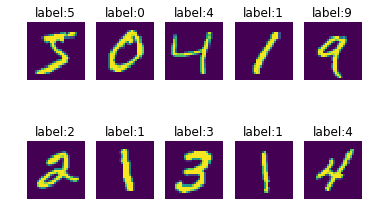

In [3]:
_x, _y = mnist_train[0]
print('Shape of an image:', _x.shape)
print('Shape of a label', _y.shape)

f, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
for i, ax in enumerate(chain(*axes)):
    _x, _y = mnist_train[i]
    ax.set_title('label:' + str(_y.item()))
    ax.set_axis_off()
    ax.imshow(_x.squeeze())

### 1.3 Dataset visualisation
- Good ol' tnse
- Flattening a 28x28 image into a 784 long vector
- No visible domain discrepancy
- Yes, tnse would be good enough to classify the dataset

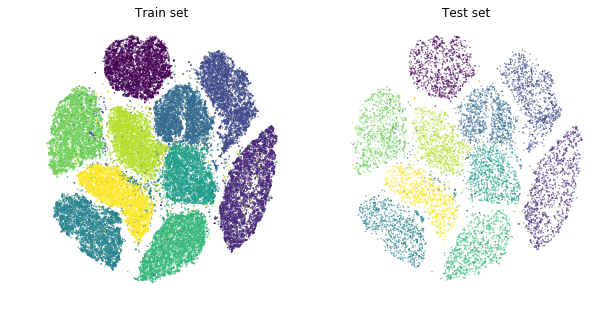

In [59]:
# Dimensionality Reduction
from MulticoreTSNE import MulticoreTSNE as TSNE

flat = torch.cat([
    mnist_train.train_data.view(len(mnist_train), -1),
    mnist_test.test_data.view(len(mnist_test), -1)
], dim=0)
print('Flattened data shape:', flat.shape)

tsne = TSNE(n_jobs=-1)
embd = tsne.fit_transform(flat.numpy())


# Plotting
f, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
f.set_size_inches(10, 5)

axes[0].scatter(x=embd[:n_train, 0], y=embd[:n_train, 1], s=0.1, 
                 c=mnist_train.train_labels.numpy())
axes[0].set_title('Train set')
axes[0].set_axis_off()

axes[1].scatter(x=embd[n_train:,0], y=embd[n_train:,1], s=0.1, 
                 c=mnist_test.test_labels.numpy())
axes[1].set_title('Test set')
axes[1].set_axis_off()

## 2. Modellling

Each layer of the network will contain the following transformations: convlolution, (optional batchnorm), activation function, pooling.  
Each transformation can be considered a separate (sub)layer since it might contain parameters that can be learned (weights), but I prefer to think of a network layer as all of these transformations in conjuction.

Understanding each transformation's representation and output:
- 2.1 Convolution
- 2.2 BatchNorm
- 2.3 ReLU
- 2.4 MaxPool

Building the final model: 2.5

### 2.1 Convolution
Convolutions themselves are just transformations and preserve the shape of the input.  
The shape can be altered by enforcing restrictions on how the windows move i.e. through stride and padding.
- \_in: a tensor of 10 (arbitrary) stacked grayscale (1 channel) images of 28x28   
- \_transform: 16 kernels of size 5x5  
- \_out: a tensor of 10 stacked grayscale images of 28x28 convoluted by 16 kernels  

In [4]:
_in = torch.stack([mnist_train[i][0] for i in range(10)])
_transform = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
_out = _transform(_in)
print('Shape of input:', _in.shape)
print('Shape of the conv weights: {} and bias: {}'.format(*[_.shape for _ in list(_transform.parameters())]))
print('Shape of the conv output:', _out.shape)

Shape of input: torch.Size([10, 1, 28, 28])
Shape of the conv weights: torch.Size([16, 1, 5, 5]) and bias: torch.Size([16])
Shape of the conv output: torch.Size([10, 16, 28, 28])


### 2.2 BatchNorm
- Parametrised by only 2 scalars (gamma, beta) per kernel
- Maintains the shape of the input as it only re-scales the values

In [5]:
_in = _out
_transform = nn.BatchNorm2d(num_features=16)
_out = _transform(_in)
print('Shape of input:', _in.shape)
print('Shape of the BatchNorm weights: {} and bias: {}'.format(*[_.shape for _ in list(_transform.parameters())]))
print('Shape of the BatchNorm output:', _out.shape)

Shape of input: torch.Size([10, 16, 28, 28])
Shape of the BatchNorm weights: torch.Size([16]) and bias: torch.Size([16])
Shape of the BatchNorm output: torch.Size([10, 16, 28, 28])


### 2.3 Relu
- Relu is an activation function, it does not have any learnable parameters
- Maintains the shape of the input, as it only applies max(x, 0) to each input x

In [6]:
_in = _out
_transform = nn.ReLU()
_out = _transform(_in)
print('Shape of input:', _in.shape)
print('Shape of the Relu parameters: {}'.format(list(_transform.parameters())))
print('Shape of the Relu output:', _out.shape)

Shape of input: torch.Size([10, 16, 28, 28])
Shape of the Relu parameters: []
Shape of the Relu output: torch.Size([10, 16, 28, 28])


### 2.4 MaxPool
- Similar to ReLU, MaxPool is a function that does not have any learned weigths - it has parameters (kernel_size, stride, padding) but none that are learnable.  
- Similar to the convolution it doesnt reduce the image size through the pooling transformation per se. The image size can be altered using stride and padding. The number of channels remains unchanged.

In [7]:
_in = _out
_transform = nn.MaxPool2d(kernel_size=2, stride=2)
_out = _transform(_in)
print('Shape of input:', _in.shape)
print('Shape of the MaxPool parameters {}'.format(list(_transform.parameters())))
print('Shape of the MaxPool output:', _out.shape)

Shape of input: torch.Size([10, 16, 28, 28])
Shape of the MaxPool parameters []
Shape of the MaxPool output: torch.Size([10, 16, 14, 14])


### 2.5 Complete model
- Grouping the Conv, BatchNorm, Relu and MaxPool transformations into a single NN layer

In [4]:
def _create_layers(layers):
    """
    List of dictionaries containing the parameters for: 
    'conv_kernels', 'conv_size', 'conv_stride', 'conv_padding', 'pool_size', 'pool_stride', 'pool_padding'
    """
    _n_channels = 1
    res = []
    for desc in layers:
        layer = nn.Sequential(
            nn.Conv2d(_n_channels, desc['conv_kernels'], kernel_size=desc['conv_size'], stride=desc['conv_stride'], padding=desc['conv_padding']),
            nn.BatchNorm2d(desc['conv_kernels'], track_running_stats=False),  # turning off moving avg and std due to batchnorm eval problems
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=desc['pool_size'], stride=desc['pool_stride'], padding=desc['pool_padding']))
        _n_channels = desc['conv_kernels']
        res.append(layer)
    return nn.Sequential(*res)


class ConvNet(nn.Module):
    def __init__(self, layers, input_size=(1, 28, 28), num_classes=10):
        super().__init__()
        self.layers = _create_layers(layers)
        out_shape = self.layers(torch.Tensor(1, *input_size)).shape
        out_size = np.array(out_shape).prod()
        self.fc = nn.Linear(out_size, num_classes)
        
    def forward(self, x):
        out = self.layers(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

## 3. Training
- 3.1 Choosing the hyperparams
- 3.2 Running the training
- 3.3 Evaluation

In [20]:
class Logger(object):
    """Logs the loss and acc over the entire train and test sets"""

    def __init__(self, log_period: int):
        """log at every `log_period` batches"""
        super().__init__()
        self.log_period = log_period
        self.iteration_count = 0
        self.logs = defaultdict(list)

    def _log(self, dataset, model):
        loader = train_loader if dataset == 'train' else test_loader
        
        with torch.no_grad():
            correct = 0
            losses = []
            for batch_X, batch_y in loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, dim=1)
                correct += (predicted == batch_y).sum().item()
                losses.append(criterion(outputs, batch_y).item())
                
            self.logs[dataset + '_loss'].append(sum(losses) / len(losses))
            self.logs[dataset + '_acc'].append(correct / len(loader.dataset))
        
    def __call__(self, model):
        self.iteration_count += 1
        if self.iteration_count % self.log_period:
            return

        model.eval()
        self._log('train', model)
        self._log('test', model)
        model.train()

### 3.1 Hyperparams
- Hyperparams for training, model architecture and optimisation

In [30]:
# training
batch_size = 100
n_epochs = 5

# model
layers = [{'conv_kernels': 20, 'conv_size': 5, 'conv_stride': 1, 'conv_padding': 2, 'pool_size': 2, 'pool_stride': 2, 'pool_padding': 1},
          {'conv_kernels': 5, 'conv_size': 5, 'conv_stride': 1, 'conv_padding': 2, 'pool_size': 2, 'pool_stride': 2, 'pool_padding': 1}
         ]

# optimsation
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()

### 3.2 Optimisation
- Instantiate the loaders, model, and all other objects required
- Run the training

In [31]:
# Init
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, num_workers=4, shuffle=False)

model = ConvNet(layers).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

logger = Logger(log_period=100)


# Training
for epoch_ix in range(n_epochs):
    for batch_ix, (batch_X, batch_y) in tqdm.tqdm(enumerate(train_loader), desc='Epoch {}'.format(epoch_ix)):
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        optimiser.zero_grad()
        criterion(model(batch_X), batch_y).backward()
        optimiser.step()
        logger(model)        

Epoch 0: 600it [00:12, 49.18it/s]
Epoch 1: 600it [00:12, 49.80it/s]
Epoch 2: 600it [00:11, 50.41it/s]
Epoch 3: 600it [00:11, 50.62it/s]
Epoch 4: 600it [00:11, 50.52it/s]


### 3.3 Evaluation
 - Predicting individual images
 - Looking at the error/acc plots

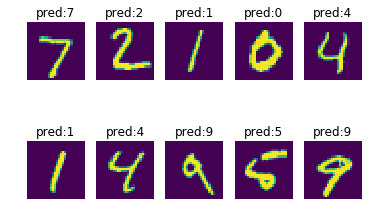

In [32]:
model.eval()
model.to('cpu')
f, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
for i, ax in enumerate(chain(*axes)):
    _x, _y = mnist_test[i]
    prediction = model(_x.view(1, 1, 28, 28)).max(dim=1)[1]
    ax.set_title('pred:' + str(prediction.item()))
    ax.set_axis_off()
    ax.imshow(_x.squeeze())

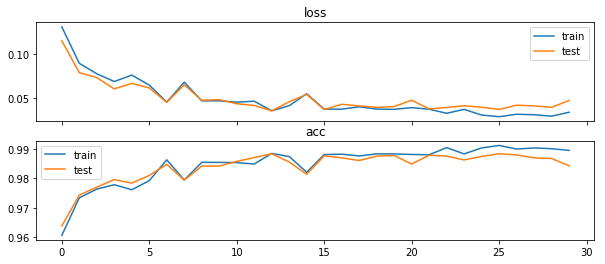

In [33]:
# each data point represents the loss or accuracy over the entire train and test set, captured after each 100 batches
f, axes = plt.subplots(2, sharex=True, figsize=(10, 4))
for ax, plot in zip(axes, ['loss', 'acc']):
    ax.set_title(plot)
    ax.plot(logger.logs['train_' + plot], label='train')
    ax.plot(logger.logs['test_' + plot], label='test')
    ax.legend()

## 4. Introspection
Looking inside the network to see what and how it learned.
- 4.1 Kernels
- 4.2 Representations

In [34]:
def plot_tensor(tensor, ncols, nrows, figsize):
    """Plot a 3D tensor along the first axis"""
    f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for ix_ax, ax in enumerate(axes.flatten()):
        ax.imshow(tensor[ix_ax].detach())
        ax.set_axis_off()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

### 4.1 Kernels
- Displaying the learned kernels on each layer

Layer 0


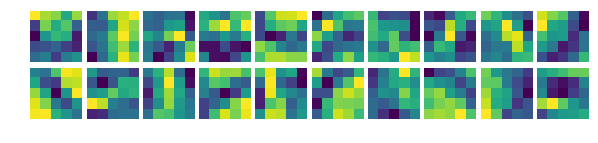

Layer 1


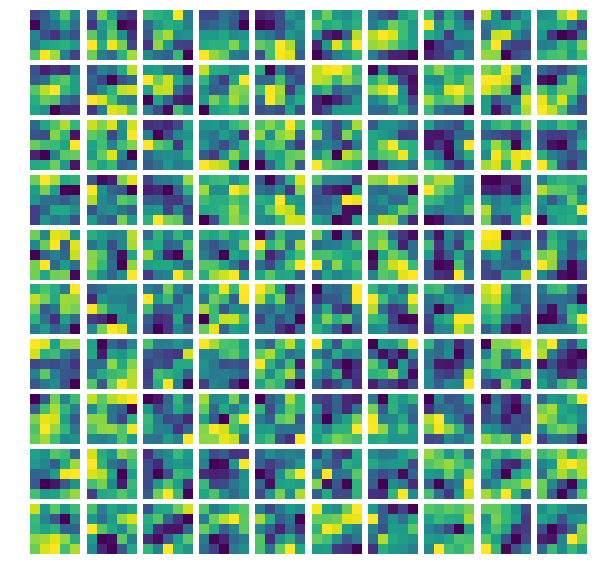

In [35]:
for ix_layer, layer in enumerate(model.layers):
    kernels = list(layer[0].parameters())[0].view(-1, 5, 5)
    print(f'Layer {ix_layer}')
    plot_tensor(kernels, ncols=10, nrows=len(kernels)//10, figsize=(10, len(kernels)/10))

### 4.2 Representations
- Running an image through the network and plotting the intermediary transformations

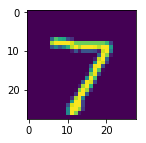

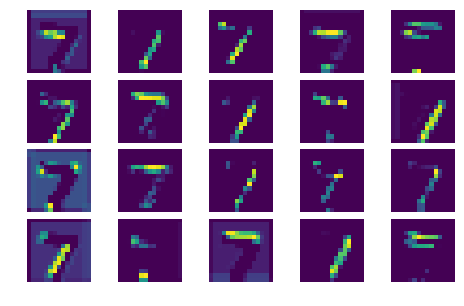

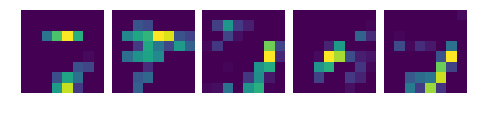

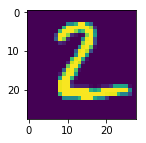

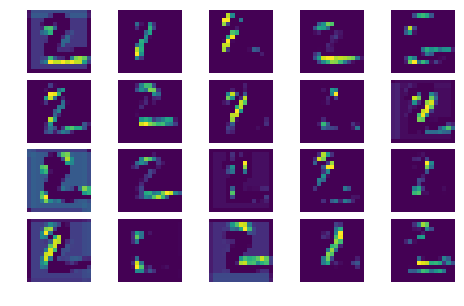

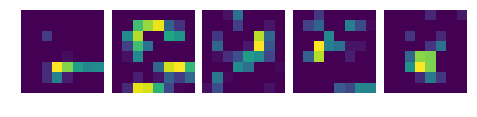

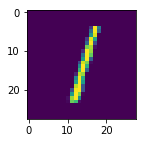

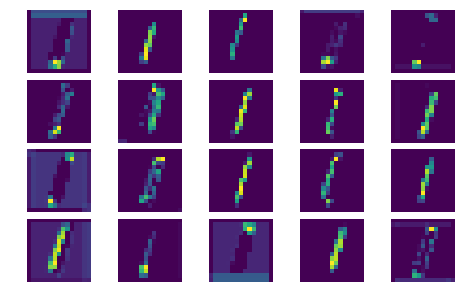

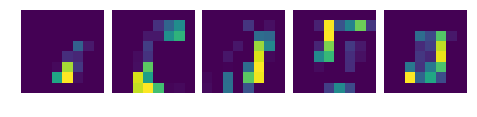

In [36]:
for i in range(3):
    _x, _y = mnist_test[i]
    plt.figure(figsize=(2, 2))
    plt.imshow(_x.squeeze())
    plt.show()
    
    out1 = model.layers[0](_x.view(1, 1, 28, 28))
    plot_tensor(out1.squeeze(), nrows=4, ncols=5, figsize=(8, 5))
    
    out2 = model.layers[1](out1)
    plot_tensor(out2.squeeze(), nrows=1, ncols=5, figsize=(8, 5))
    print('\n\n\n')